In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.random_graph_dataset as random_graph_dataset
import feature.graph_conversions as graph_conversions
import model.discrete_diffusers as discrete_diffusers
import model.generate as generate
import model.gnn as gnn
import analysis.graph_metrics as graph_metrics
import analysis.mmd as mmd
import torch
import torch_geometric
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Create the data loader

In [3]:
# Create the data loader for training
node_dim = 5

dataset = random_graph_dataset.RandomGraphDataset(
    node_dim, num_items=6400,
    graph_type="diverse_cliques", clique_sizes=[3, 4, 5, 6], noise_level=0, unity_features=True
)
data_loader = torch_geometric.loader.DataLoader(
    dataset, batch_size=32, shuffle=True, num_workers=0  # TODO: allow multi-processing
)

### Create the model

In [4]:
# Create the diffuser and model
diffuser = discrete_diffusers.BernoulliOneSkipDiffuser(100, 10, (1,))  # Make input shape just 1
t_limit = 1000

model = gnn.GraphLinkGAT(
    node_dim, t_limit,
    num_gnn_layers=5
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/discrete_graph_diffusion/models/trained_models/misc"

import model.train_model as train_model  # Import this AFTER setting environment

### Show the forward-diffusion process

/gstore/home/tsenga5/miniconda3/envs/graph-diff/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  data[key] = torch.tensor(value)


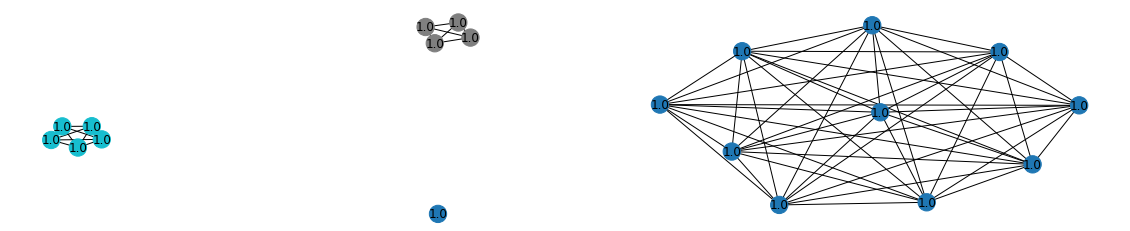

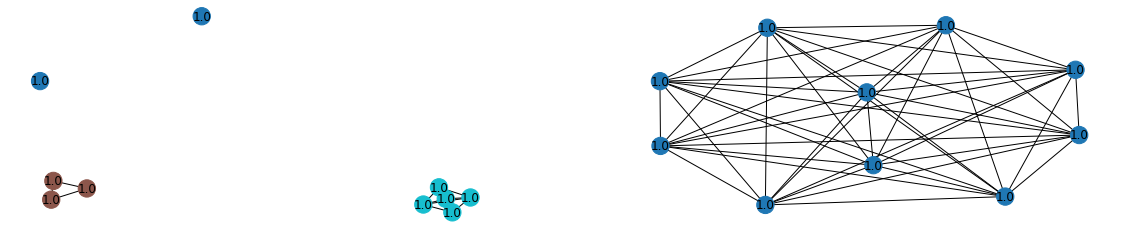

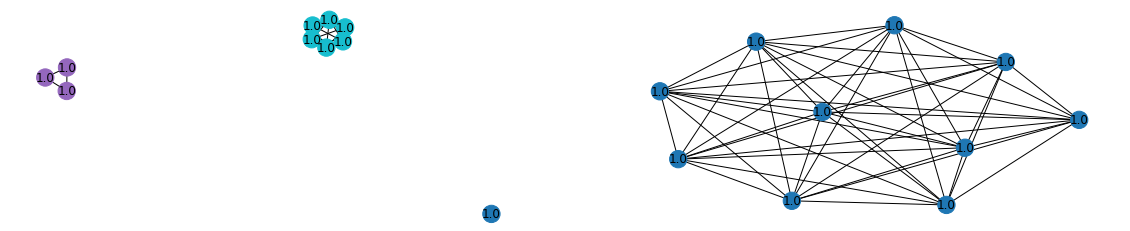

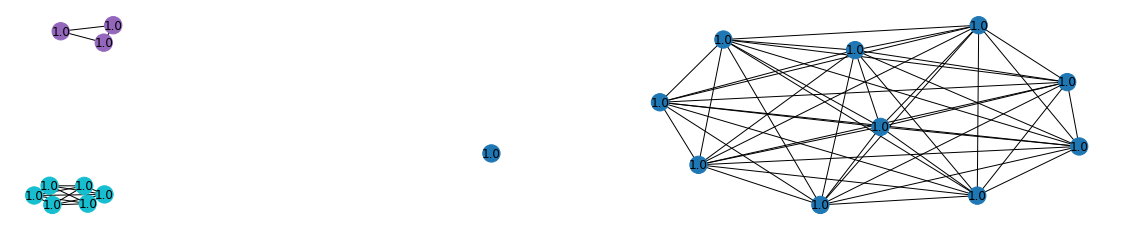

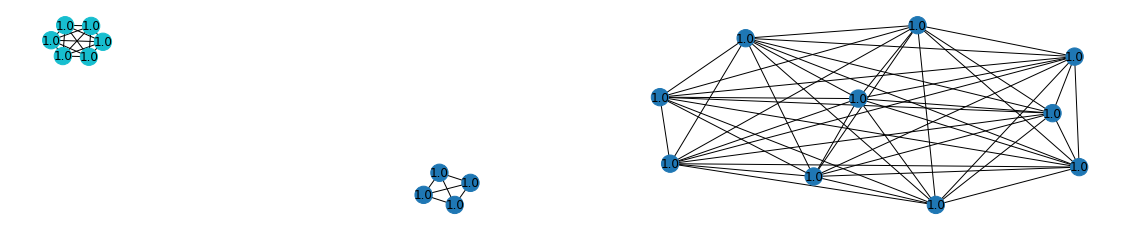

In [5]:
# Check the NetworkX graphs in a batch directly from the data loader, and
# after adding noise for a long time
data = next(iter(data_loader))

graphs_0 = graph_conversions.split_pyg_data_to_nx_graphs(data)

e0, edge_batch_inds = graph_conversions.pyg_data_to_edge_vector(data, return_batch_inds=True)
t_e = torch.tile(torch.tensor([t_limit], device=DEVICE), (e0.shape[0],))
et = diffuser.forward(e0[:, None], t_e, return_posterior=False)[:, 0]  # Do the noising on E x 1 tensors
data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, et)

graphs_t = graph_conversions.split_pyg_data_to_nx_graphs(data)

for i in np.random.choice(len(graphs_0), replace=False, size=min(5, len(graphs_0))):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    degrees = dict(graphs_0[i].degree())
    node_degrees = [degrees[n] for n in range(len(graphs_0[i]))]
    mean_feats = np.mean(graph_conversions.get_nx_node_features(graphs_0[i]), axis=1)
    labels = {i : round(mean_feats[i], 2) for i in range(len(mean_feats))}
    nx.draw(graphs_0[i], ax=ax[0], node_color=node_degrees, labels=labels, cmap="tab10")
    degrees = dict(graphs_t[i].degree())
    node_degrees = [degrees[n] for n in range(len(graphs_0[i]))]
    mean_feats = np.mean(graph_conversions.get_nx_node_features(graphs_t[i]), axis=1)
    labels = {i : round(mean_feats[i], 2) for i in range(len(mean_feats))}
    nx.draw(graphs_t[i], ax=ax[1], node_color=node_degrees, labels=labels, cmap="tab10")
    plt.show()

  0%|          | 0/999 [00:00<?, ?it/s]

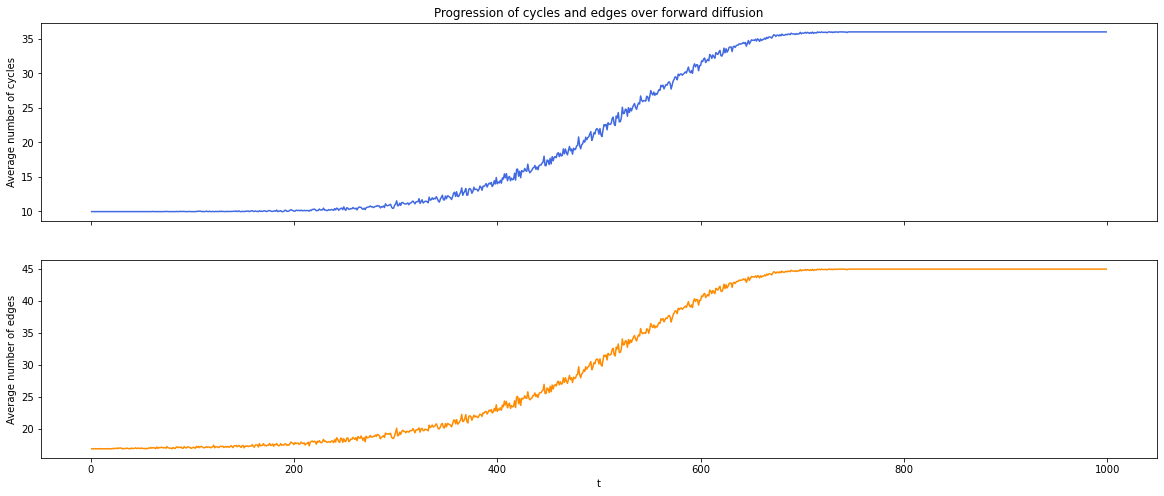

In [6]:
# Check progression of the number of cycles and edges
t_vals = np.arange(1, t_limit)
num_cycles = np.empty((len(t_vals), data_loader.batch_size))
num_edges = np.empty((len(t_vals), data_loader.batch_size))
data = next(iter(data_loader))
e0 = graph_conversions.pyg_data_to_edge_vector(data)
for i, t in tqdm.notebook.tqdm(enumerate(t_vals), total=len(t_vals)):
    t_tens = torch.tensor([t], device=DEVICE)
    et = diffuser.forward(e0[None], t_tens, return_posterior=False)[0]  # Do the noising on 1 x E tensors
    data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, et)  # Note: this modifies `data`
    
    # Convert to a list of NetworkX graphs
    graphs = graph_conversions.split_pyg_data_to_nx_graphs(data)
    for j, g in enumerate(graphs):
        num_cycles[i, j] = len(nx.cycle_basis(g))
        num_edges[i, j] = nx.number_of_edges(g)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 8))
ax[0].plot(t_vals, np.mean(num_cycles, axis=1), color="royalblue")
ax[0].set_ylabel("Average number of cycles")

ax[1].plot(t_vals, np.mean(num_edges, axis=1), color="darkorange")
ax[1].set_ylabel("Average number of edges")
ax[1].set_xlabel("t")

ax[0].set_title("Progression of cycles and edges over forward diffusion")
plt.show()

  0%|          | 0/999 [00:00<?, ?it/s]

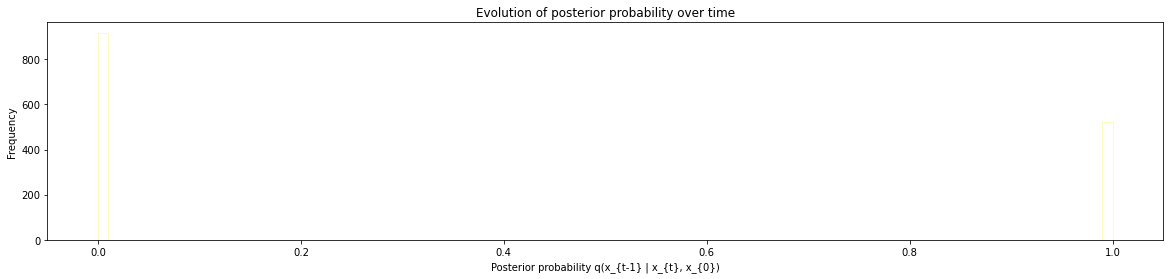

In [7]:
# Check progression of posterior probability
t_vals = np.arange(1, t_limit)
data = next(iter(data_loader))
e0 = graph_conversions.pyg_data_to_edge_vector(data)
posterior_probs = np.empty((len(t_vals), e0.shape[0]))
for i, t in tqdm.notebook.tqdm(enumerate(t_vals), total=len(t_vals)):
    t_tens = torch.tensor([t], device=DEVICE)
    et, p = diffuser.forward(e0[None], t_tens)  # Do the noising on 1 x E tensors
    et, p = et[0], p[0]
    posterior_probs[i] = p.cpu().numpy()
    
fig, ax = plt.subplots(figsize=(20, 4))
times = np.tile(t_vals[:, None], (1, posterior_probs.shape[1]))
cmap = plt.get_cmap("magma")
bins = np.linspace(0, 1, 100)
for t_i in range(len(t_vals)):
    ax.hist(posterior_probs[t_i], bins=bins, histtype="step", color=cmap(t_i / len(t_vals)), alpha=0.5)
ax.set_xlabel("Posterior probability q(x_{t-1} | x_{t}, x_{0})")
ax.set_ylabel("Frequency")
ax.set_title("Evolution of posterior probability over time")
plt.show()

### Train the model

In [21]:
train_model.train_ex.run(
    "train_graph_model",
    config_updates={
        "model": model,
        "diffuser": diffuser,
        "data_loader": data_loader,
        "num_epochs": 90,
        "learning_rate": 0.001,
        "t_limit": t_limit
    }
)

WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "diffuser"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_graph_model'
INFO - train - Started run with ID "137"
Loss: 0.2212: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.70it/s]


Epoch 1 average Loss: 0.2123


Loss: 0.2395: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.69it/s]


Epoch 2 average Loss: 0.2139


Loss: 0.1938: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.68it/s]


Epoch 3 average Loss: 0.2121


Loss: 0.1433: 100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.64it/s]


Epoch 4 average Loss: 0.2068


Loss: 0.1441: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.67it/s]


Epoch 5 average Loss: 0.2078


Loss: 0.2266: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.67it/s]


Epoch 6 average Loss: 0.2061


Loss: 0.2409: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.67it/s]


Epoch 7 average Loss: 0.2105


Loss: 0.2061: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.67it/s]


Epoch 8 average Loss: 0.2146


Loss: 0.1468: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.70it/s]


Epoch 9 average Loss: 0.2098


Loss: 0.1860: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.68it/s]


Epoch 10 average Loss: 0.2061


Loss: 0.2477: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.66it/s]


Epoch 11 average Loss: 0.2051


Loss: 0.2498: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.70it/s]


Epoch 12 average Loss: 0.2056


Loss: 0.1866: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.69it/s]


Epoch 13 average Loss: 0.2042


Loss: 0.1953: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.69it/s]


Epoch 14 average Loss: 0.2026


Loss: 0.1885: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.68it/s]


Epoch 15 average Loss: 0.2050


Loss: 0.1857: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.67it/s]


Epoch 16 average Loss: 0.2050


Loss: 0.1406: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.68it/s]


Epoch 17 average Loss: 0.2046


Loss: 0.2119: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.67it/s]


Epoch 18 average Loss: 0.2040


Loss: 0.2084: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.66it/s]


Epoch 19 average Loss: 0.2037


Loss: 0.1620: 100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.62it/s]


Epoch 20 average Loss: 0.2000


Loss: 0.2478: 100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.64it/s]


Epoch 21 average Loss: 0.1990


Loss: 0.2342: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.66it/s]


Epoch 22 average Loss: 0.1983


Loss: 0.2819: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.65it/s]


Epoch 23 average Loss: 0.1997


Loss: 0.1782: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.66it/s]


Epoch 24 average Loss: 0.1968


Loss: 0.2422: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.66it/s]


Epoch 25 average Loss: 0.1980


Loss: 0.1568: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.67it/s]


Epoch 26 average Loss: 0.1981


Loss: 0.3688: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.65it/s]


Epoch 27 average Loss: 0.2031


Loss: 0.1631: 100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.65it/s]


Epoch 28 average Loss: 0.1997


Loss: 0.1938: 100%|█████████████████████████████████████████| 200/200 [00:43<00:00,  4.65it/s]


Epoch 29 average Loss: 0.1983


Loss: 0.2218: 100%|█████████████████████████████████████████| 200/200 [00:42<00:00,  4.67it/s]
INFO - train - Completed after 0:21:47


Epoch 30 average Loss: 0.2009


### Show generated graphs

In [22]:
# Take the trained model and go backwards to sample some graphs
print("Sampling some reverse trajectories")

# Sample from the prior
data = next(iter(data_loader))
edges = graph_conversions.pyg_data_to_edge_vector(data)
sampled_edges = diffuser.sample_prior(
    edges.shape[0], # Samples will be E x 1
    torch.tile(torch.tensor([t_limit], device=DEVICE), edges.shape)
)[:, 0]  # Shape: E
data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, sampled_edges)

samples, times = generate.generate_graph_samples(
    model, diffuser, data, t_limit=t_limit, return_all_times=True, verbose=True
)
times = times.cpu().numpy()
# Split samples into individual graphs
graph_samples = [
    graph_conversions.split_pyg_data_to_nx_graphs(sample)
    for sample in tqdm.notebook.tqdm(samples)
]

Sampling some reverse trajectories


1000it [01:02, 15.97it/s]


  0%|          | 0/1001 [00:00<?, ?it/s]

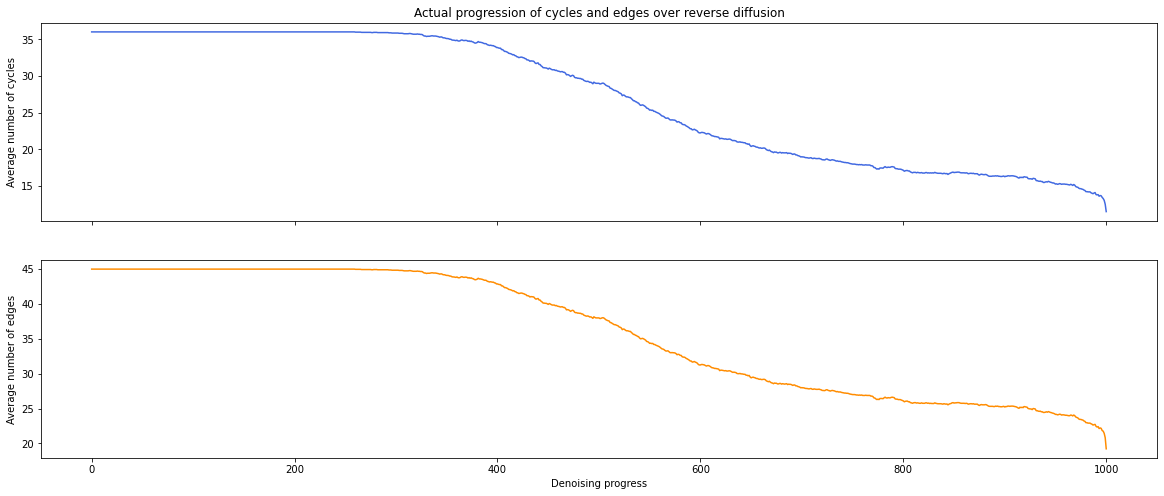

In [23]:
# Check progression of the number of cycles and edges
num_cycles = np.empty((len(graph_samples), len(graph_samples[0])))
num_edges = np.empty((len(graph_samples), len(graph_samples[0])))
for i in range(len(graph_samples)):
    for j, g in enumerate(graph_samples[i]):
        num_cycles[i, j] = len(nx.cycle_basis(g))
        num_edges[i, j] = nx.number_of_edges(g)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 8))
ax[0].plot(np.arange(len(graph_samples)), np.mean(num_cycles, axis=1), color="royalblue")
ax[0].set_ylabel("Average number of cycles")

ax[1].plot(np.arange(len(graph_samples)), np.mean(num_edges, axis=1), color="darkorange")
ax[1].set_ylabel("Average number of edges")
ax[1].set_xlabel("Denoising progress")

ax[0].set_title("Actual progression of cycles and edges over reverse diffusion")
plt.show()

0


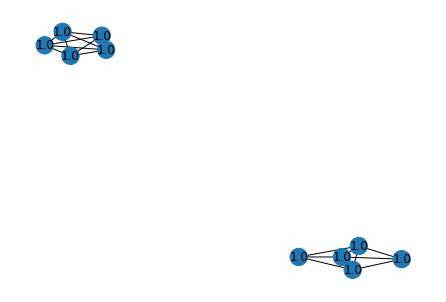

1


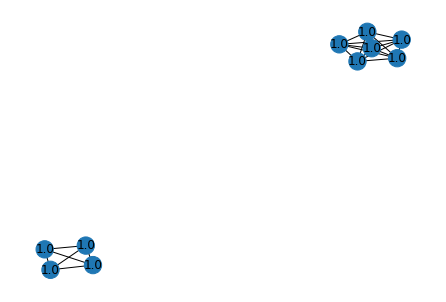

2


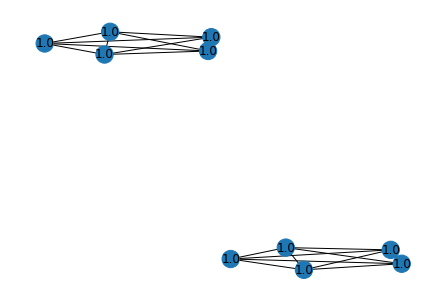

3


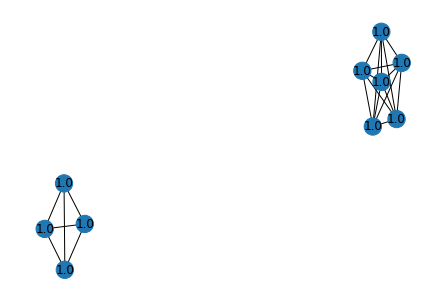

4


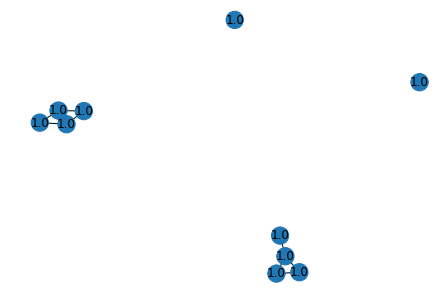

5


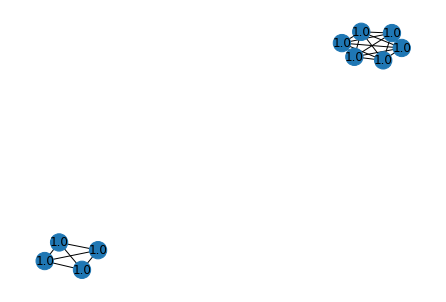

6


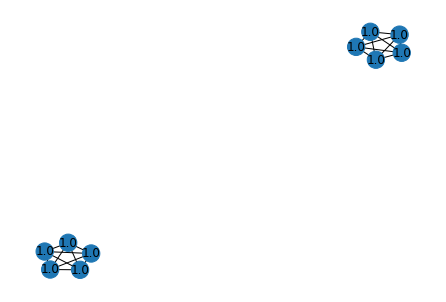

7


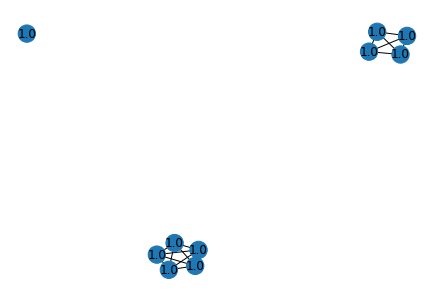

8


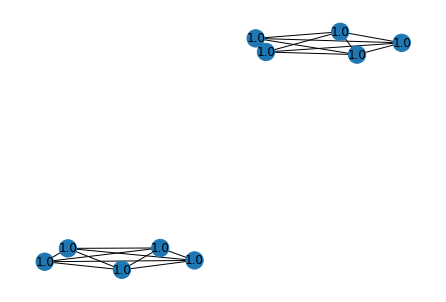

9


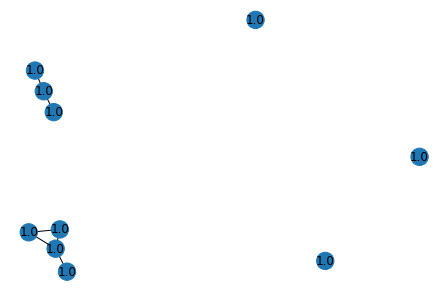

10


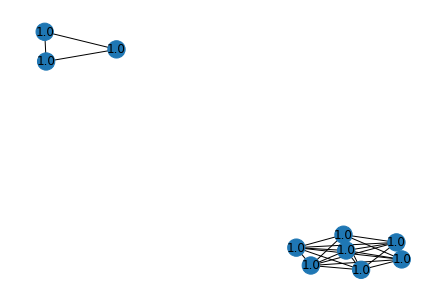

11


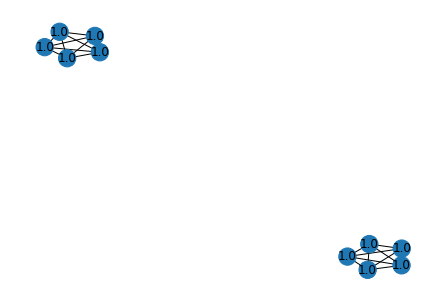

12


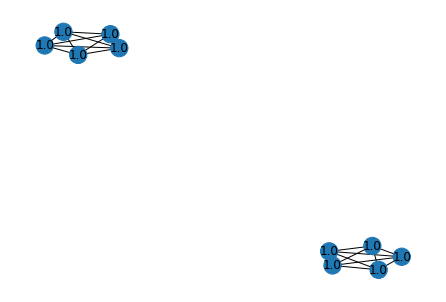

13


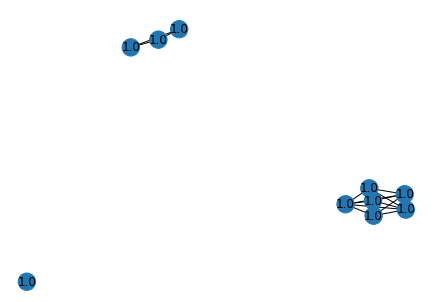

14


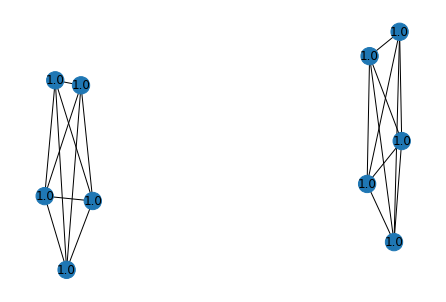

15


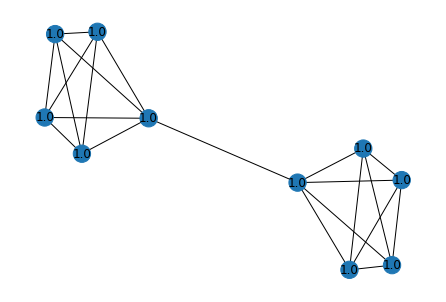

16


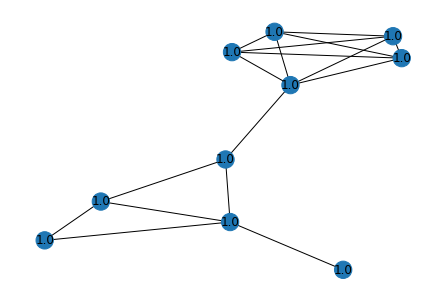

17


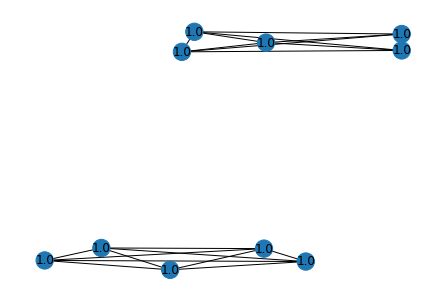

18


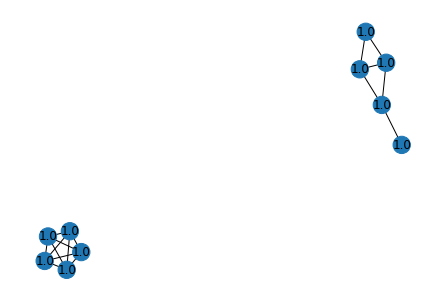

19


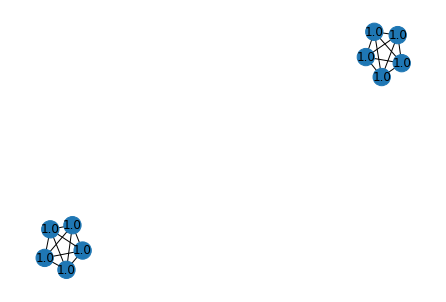

20


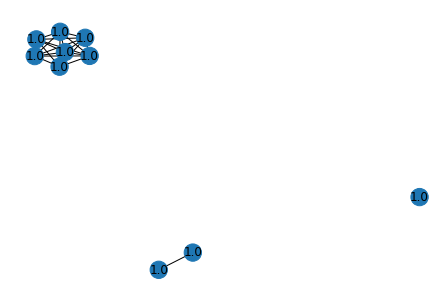

21


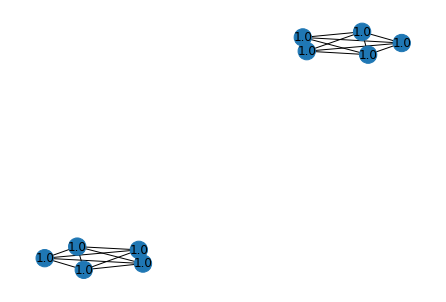

22


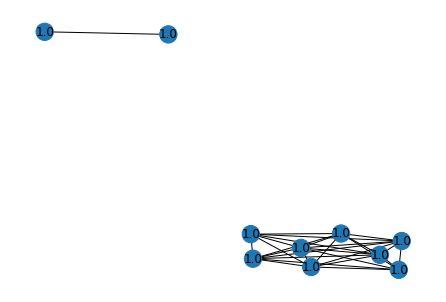

23


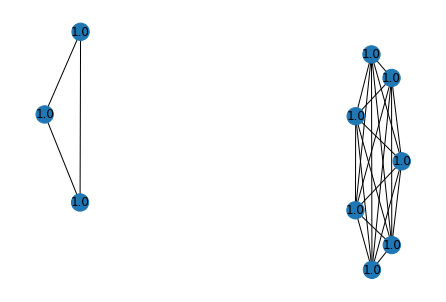

24


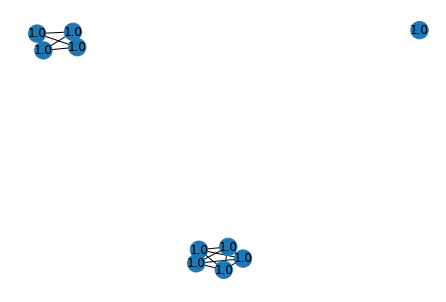

25


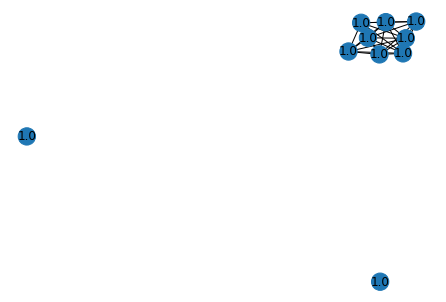

26


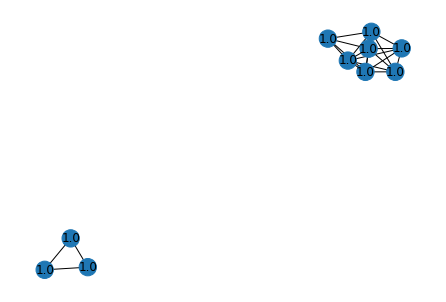

27


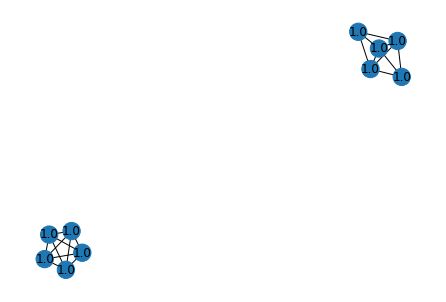

28


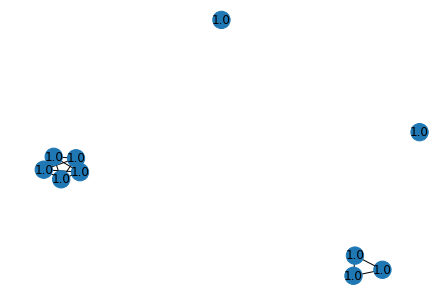

29


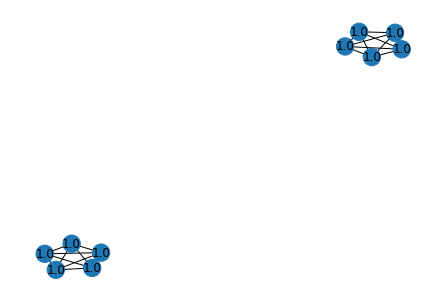

30


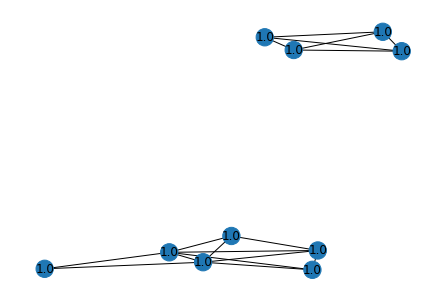

31


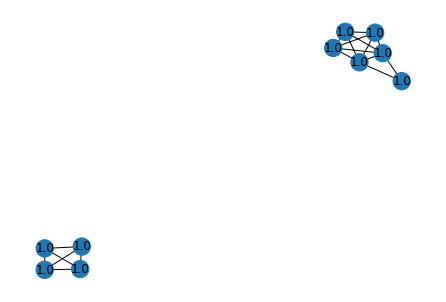

In [24]:
# Plot some randomly generated graphs
for i in range(len(graph_samples[-1])):
    print(i)
    g = graph_samples[-1][i]
    degrees = dict(g.degree())
    node_degrees = [degrees[n] for n in range(len(g))]
    mean_feats = np.mean(graph_conversions.get_nx_node_features(g), axis=1)
    labels = {i : round(mean_feats[i], 2) for i in range(len(mean_feats))}
    nx.draw(g, node_color=[round(labels[i]) for i in range(len(labels))], labels=labels, cmap="tab10")
    plt.show()

### Controllable generation

In [25]:
# Sample from the prior
data = next(iter(data_loader))
edges = graph_conversions.pyg_data_to_edge_vector(data)
sampled_edges = diffuser.sample_prior(
    edges.shape[0], # Samples will be E x 1
    torch.tile(torch.tensor([t_limit], device=DEVICE), edges.shape)
)[:, 0]  # Shape: E
data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, sampled_edges)

# Make sure our prior is the complete graph
assert torch.all(sampled_edges == 1).item()

# Pick a single clique to retain in each graph
# TODO: this is still rather inefficient
all_edges_inds = graph_conversions.edge_vector_to_pyg_data(data, 1, reflect=False)
all_edges_vec = graph_conversions.pyg_data_to_edge_vector(data)
assert all_edges_inds.shape[1] == all_edges_vec.shape[0]
retain_mask = torch.full(all_edges_vec.shape, False)
for i in range(len(data.ptr) - 1):
    start, end = data.ptr[i], data.ptr[i + 1]
    
    # Arbitrarily make the first 6 a clique
    for ind_2 in range(start, start + 6):
        for ind_1 in range(start, ind_2):
            m = (all_edges_inds[0, :] == ind_1) & (all_edges_inds[1, :] == ind_2)
            assert torch.sum(m).item() == 1
            retain_mask[m] = True
            
# Go through sampling procedure
samples = [data]
data_t = data
for t in tqdm.notebook.trange(t_limit, 0, -1):
    data_t = generate.generate_graph_samples(
        model, diffuser, data_t, t_limit=t, t_start=(t - 1)
    )
    
    # Make sure the edges we want to exist will exist
    edges_t = graph_conversions.pyg_data_to_edge_vector(data_t)
    edges_t[retain_mask] = 1
    data_t.edge_index = graph_conversions.edge_vector_to_pyg_data(data, edges_t)
    
    samples.append(data_t)

graph_samples = [
    graph_conversions.split_pyg_data_to_nx_graphs(sample)
    for sample in tqdm.notebook.tqdm(samples)
]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

0


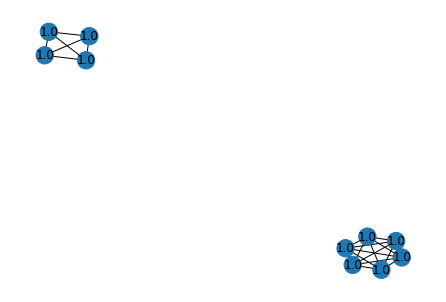

1


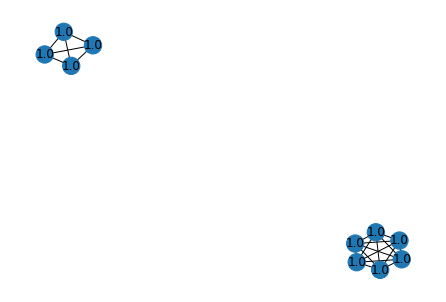

2


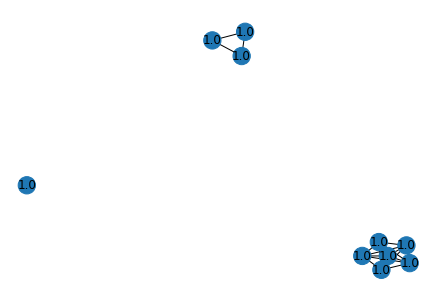

3


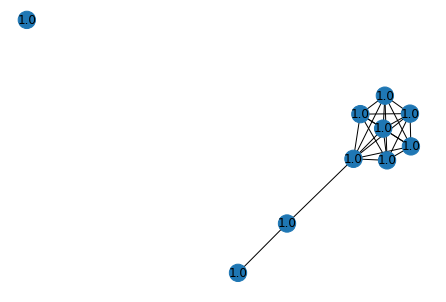

4


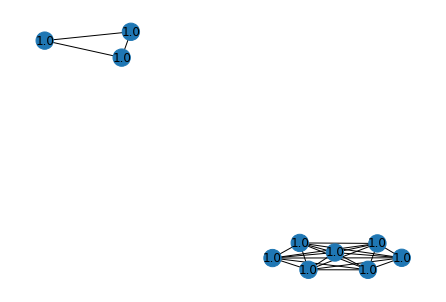

5


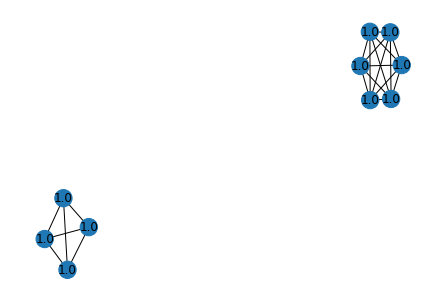

6


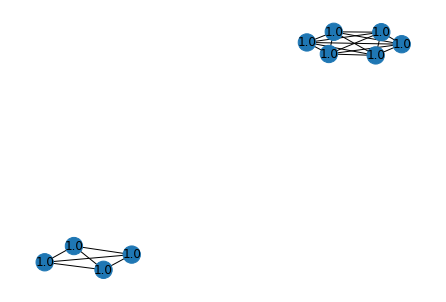

7


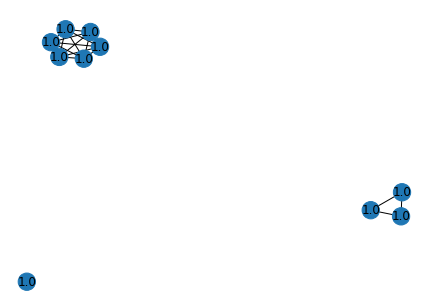

8


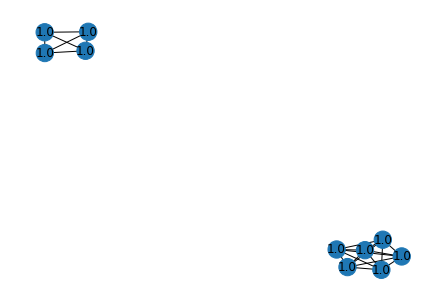

9


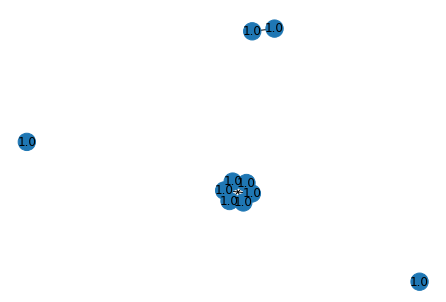

10


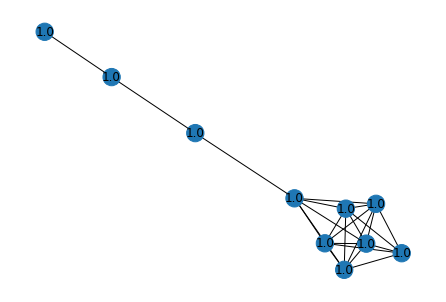

11


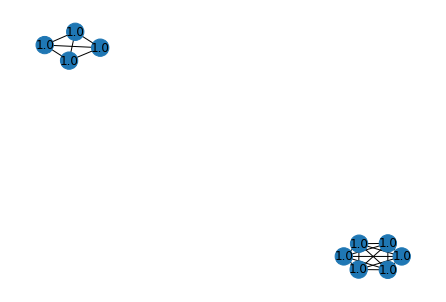

12


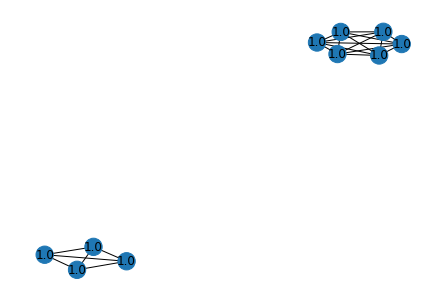

13


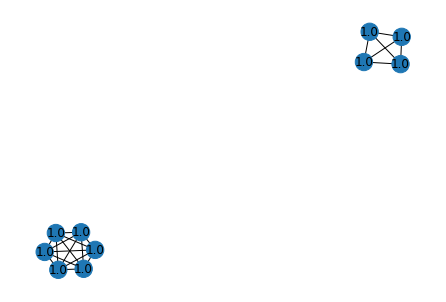

14


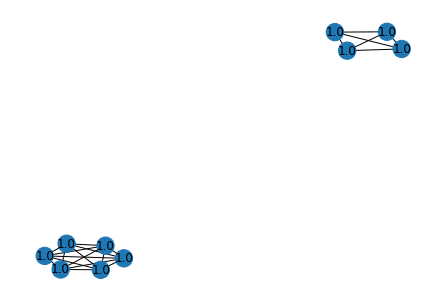

15


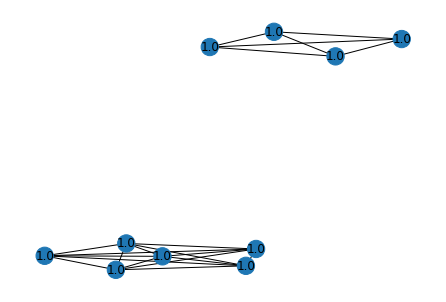

16


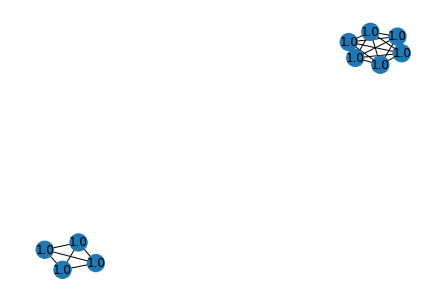

17


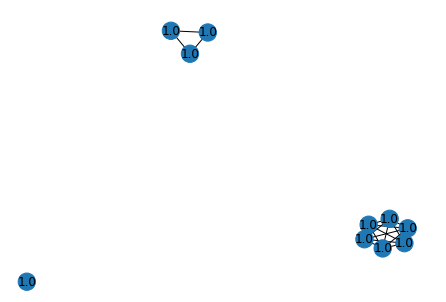

18


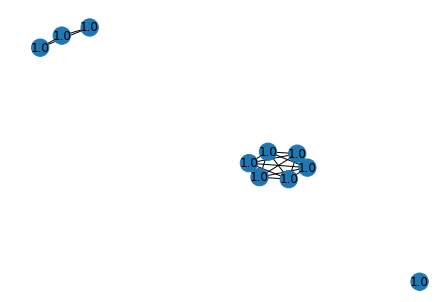

19


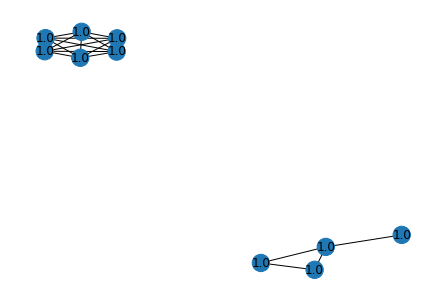

20


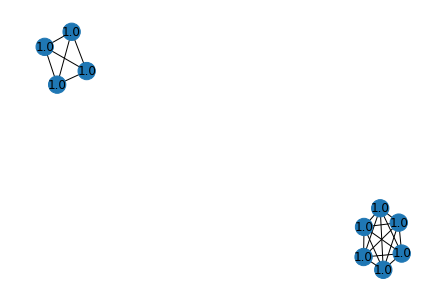

21


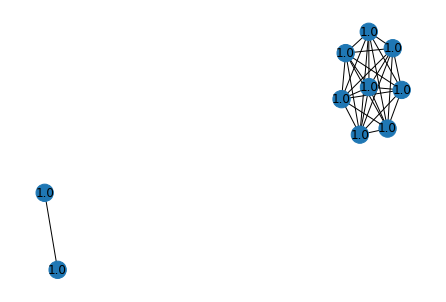

22


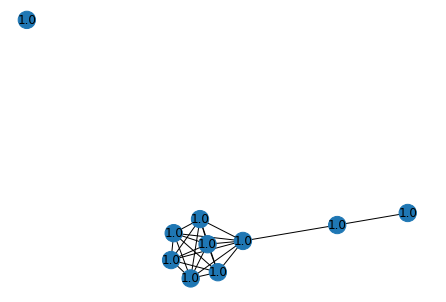

23


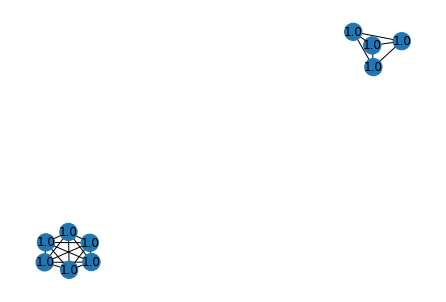

24


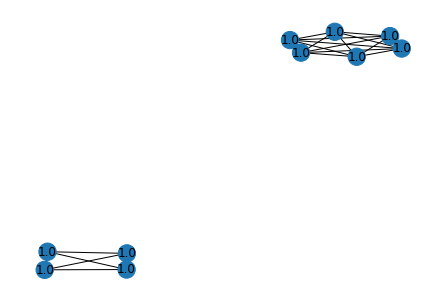

25


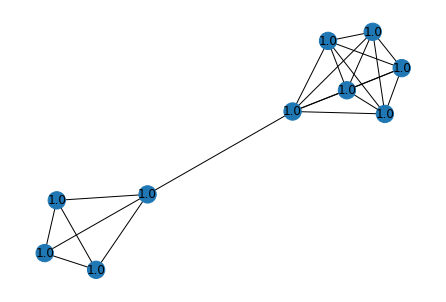

26


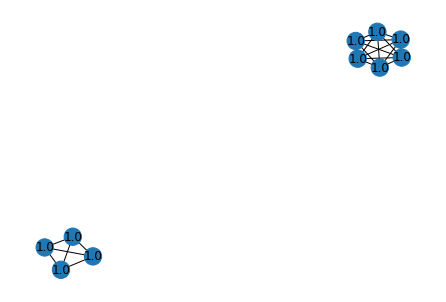

27


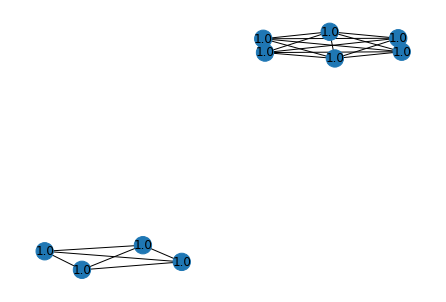

28


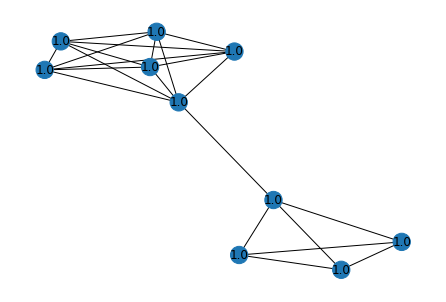

29


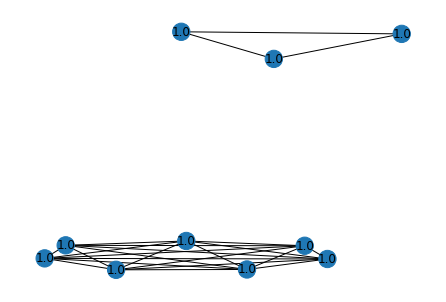

30


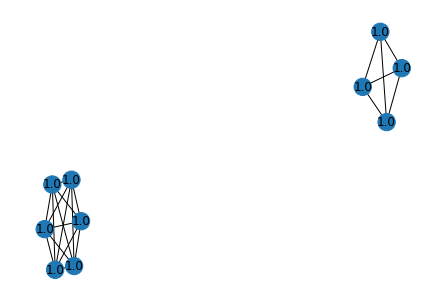

31


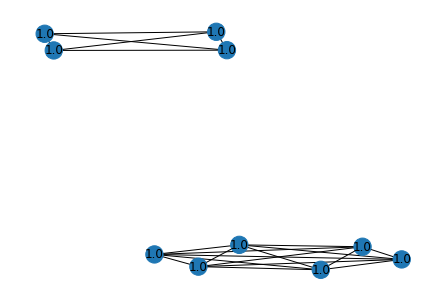

In [26]:
# Plot some randomly generated graphs
for i in range(len(graph_samples[-1])):
    print(i)
    g = graph_samples[-1][i]
    degrees = dict(g.degree())
    node_degrees = [degrees[n] for n in range(len(g))]
    mean_feats = np.mean(graph_conversions.get_nx_node_features(g), axis=1)
    labels = {i : round(mean_feats[i], 2) for i in range(len(mean_feats))}
    nx.draw(g, node_color=[round(labels[i]) for i in range(len(labels))], labels=labels, cmap="tab10")
    plt.show()